# **STAT 448: Assignment 3**
Gemma Dela Cruz (Student ID: 99509856) 

Ancy John (Student ID: 52770710)

# Importing needed libraries

Here we just import libraries from which we will need functions later.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Utility functions
We created this function in order to help us to display loss function value and accuracy of our neural network model

In [0]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()

# Main section

We will be using the FASHION-MNIST dataset, which is built into Keras.
[FASHION-MNIST](https://keras.io/api/datasets/fashion_mnist/)

In [0]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

There is no class names added with the MNIST dataset, so we need to map every picture to one label.

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [31]:
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2])

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training response shape:,  (60000,)
Testing response shape:  (10000,)


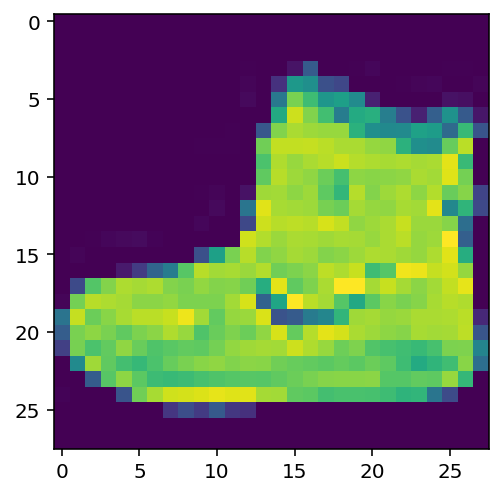

In [22]:
plt.imshow(x_train[0])

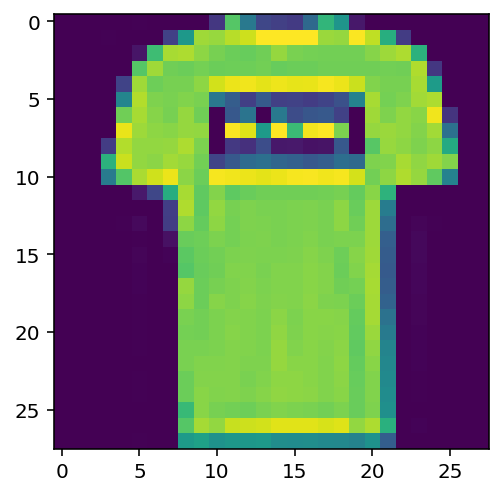

In [23]:
plt.imshow(x_train[1])

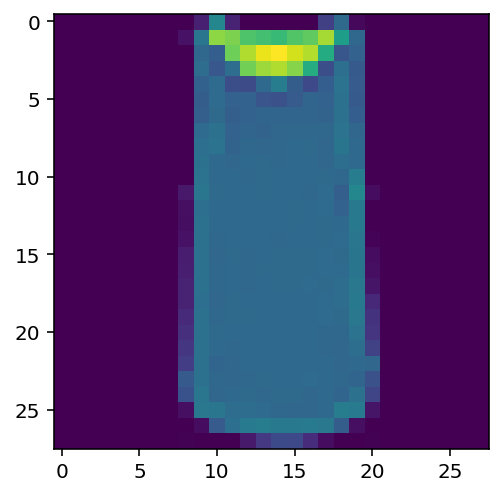

In [0]:
plt.imshow(x_train[2])

Let us see the range of pixel values using colorbar()

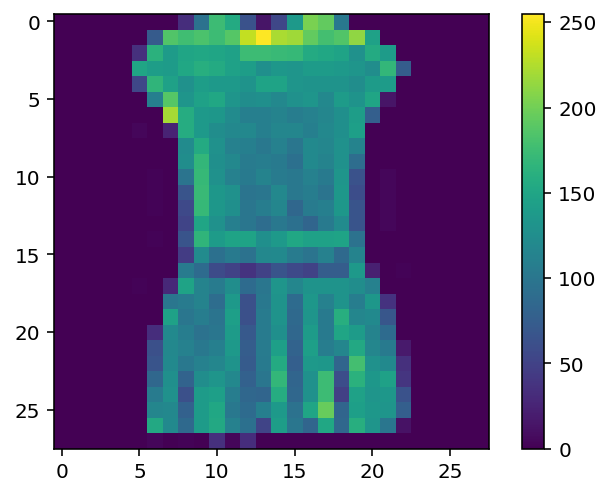

In [33]:
plt.figure()
plt.imshow(x_train[3])
plt.colorbar()
plt.grid(False)
plt.show()

In [0]:
# To normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

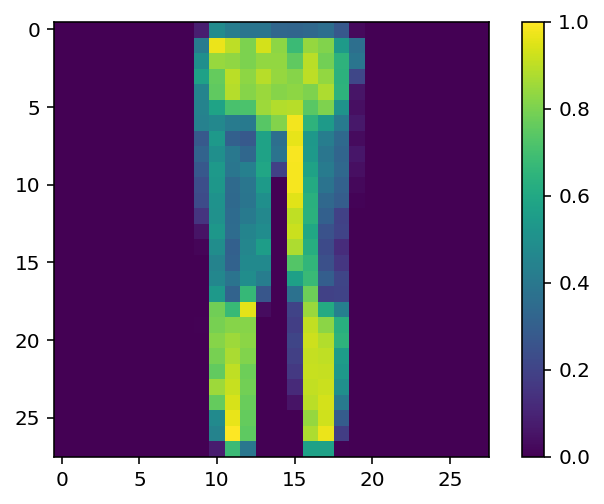

In [41]:
plt.figure()
plt.imshow(x_test[3])
plt.colorbar()
plt.grid(False)
plt.show()

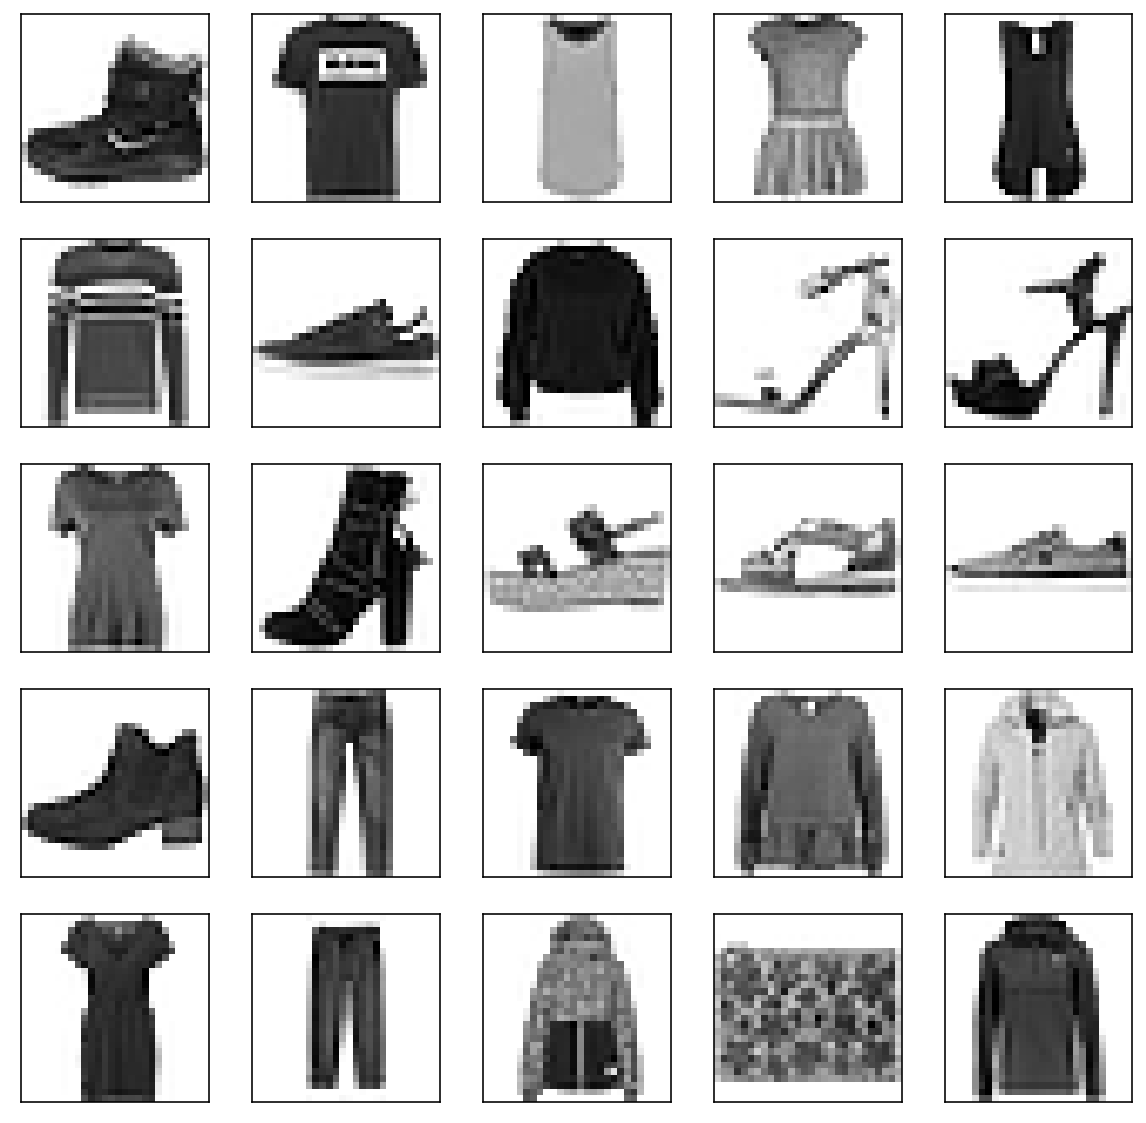

In [60]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    #plt.xlabel(class_names[x_train[i]])
plt.show()

Compile the model

In [61]:
# Flatten the images
image_vector_size = image_size[0] * image_size[1] # 28 * 28
x_train = x_train.reshape(x_train.shape[0], image_vector_size) /255.
x_test = x_test.reshape(x_test.shape[0], image_vector_size) /255.
print(x_train.shape)

(60000, 784)


In [62]:
print("First 5 training labels: ", y_train[:5]) # [9 0 0 3 0]

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [9 0 0 3 0]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(60000, 10)


In [63]:
#TRIAL NO. 1
model = Sequential()
keras.layers.Flatten(input_shape=(28, 28)),
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=512, epochs=20, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 26us/step - loss: 1.0860 - accuracy: 0.6034 - val_loss: 0.6694 - val_accuracy: 0.7390
Epoch 2/20
54000/54000 [==============================] - 1s 21us/step - loss: 0.6022 - accuracy: 0.7776 - val_loss: 0.5456 - val_accuracy: 0.8032
Epoch 3/20
54000/54000 [==============================] - 1s 21us/step - loss: 0.5196 - accuracy: 0.8117 - val_loss: 0.5053 - val_accuracy: 0.8147
Epoch 4/20
54000/54000 [==============================] - 1s 21us/step - loss: 0.4787 - accuracy: 0.8286 - val_loss: 0.4593 - val_accuracy: 0.8315
Epoch 5/20
54000/54000 [==============================] - 1s 21us/step - loss: 0.4467 - accuracy: 0.8401 - val_loss: 0.4374 - val_accuracy: 0.8372
Epoch 6/20
54000/54000 [==============================] - 1s 22us/step - loss: 0.4278 - accuracy: 0.8464 - val_loss: 0.4382 - val_accuracy: 0.8398
Epoch 7/20
54000/54000 [==============================] - 1s 22us/ste

In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


TRIAL NO. 1
Test loss: 0.385
Test accuracy: 0.863


<Figure size 576x432 with 0 Axes>

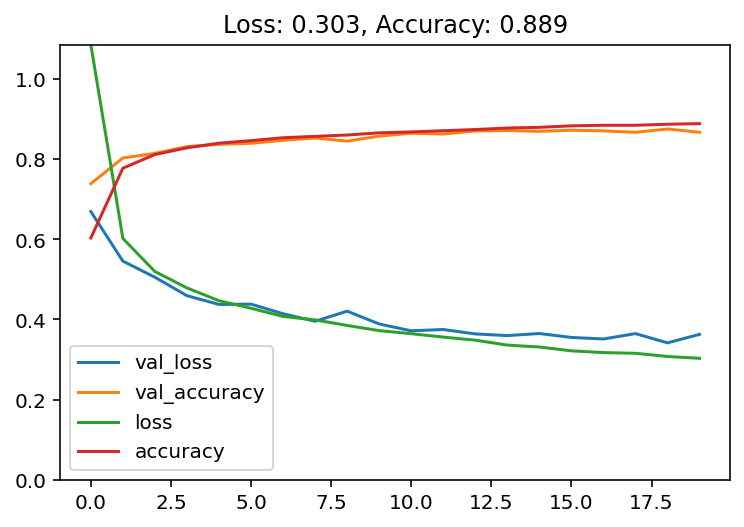

In [64]:
#TRIAL NO. 1
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 1')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 2
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=512, epochs=20, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 26us/step - loss: 0.7329 - accuracy: 0.7362 - val_loss: 0.4411 - val_accuracy: 0.8363
Epoch 2/20
54000/54000 [==============================] - 1s 23us/step - loss: 0.4800 - accuracy: 0.8273 - val_loss: 0.4002 - val_accuracy: 0.8488
Epoch 3/20
54000/54000 [==============================] - 1s 23us/step - loss: 0.4412 - accuracy: 0.8391 - val_loss: 0.3872 - val_accuracy: 0.8598
Epoch 4/20
54000/54000 [==============================] - 1s 23us/step - loss: 0.4255 - accuracy: 0.8469 - val_loss: 0.3765 - val_accuracy: 0.8588
Epoch 5/20
54000/54000 [==============================] - 1s 22us/step - loss: 0.3974 - accuracy: 0.8557 - val_loss: 0.3882 - val_accuracy: 0.8490
Epoch 6/20
54000/54000 [==============================] - 1s 23us/step - loss: 0.3919 - accuracy: 0.8577 - val_loss: 0.3624 - val_accuracy: 0.8665
Epoch 7/20
54000/54000 [==============================] - 1s 23us/ste

TRIAL NO. 2
Test loss: 0.371
Test accuracy: 0.864


<Figure size 576x432 with 0 Axes>

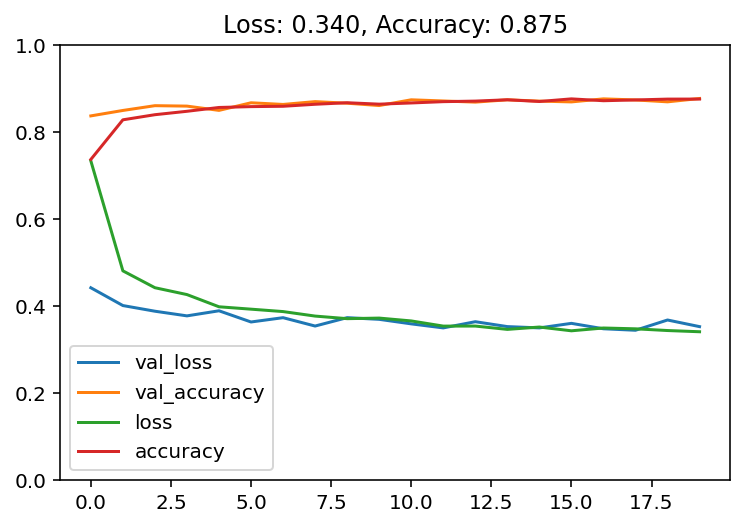

In [0]:
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 2')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 3
model = Sequential()
model.add(Dense(units=128, activation='sigmoid', input_shape=(image_vector_size,)))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =nadam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256, epochs=20, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 3s 53us/step - loss: 0.6235 - accuracy: 0.7701 - val_loss: 0.5124 - val_accuracy: 0.8032
Epoch 2/20
54000/54000 [==============================] - 2s 29us/step - loss: 0.4092 - accuracy: 0.8492 - val_loss: 0.3877 - val_accuracy: 0.8533
Epoch 3/20
54000/54000 [==============================] - 2s 29us/step - loss: 0.3645 - accuracy: 0.8657 - val_loss: 0.3456 - val_accuracy: 0.8713
Epoch 4/20
54000/54000 [==============================] - 2s 29us/step - loss: 0.3450 - accuracy: 0.8716 - val_loss: 0.3356 - val_accuracy: 0.8750
Epoch 5/20
54000/54000 [==============================] - 2s 30us/step - loss: 0.3270 - accuracy: 0.8787 - val_loss: 0.3386 - val_accuracy: 0.8765
Epoch 6/20
54000/54000 [==============================] - 2s 29us/step - loss: 0.3149 - accuracy: 0.8817 - val_loss: 0.3210 - val_accuracy: 0.8845
Epoch 7/20
54000/54000 [==============================] - 2s 29us/ste

TRIAL NO. 3
Test loss: 0.371
Test accuracy: 0.864


<Figure size 576x432 with 0 Axes>

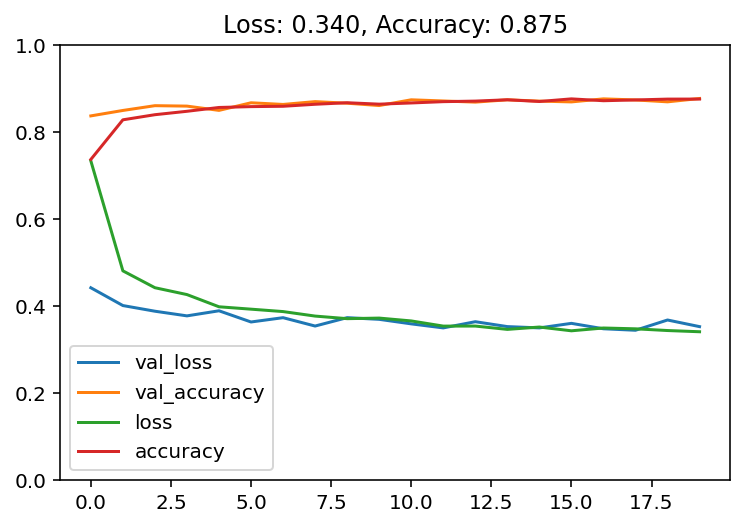

In [0]:
#TRIAL NO. 3
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 3')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 4
model = Sequential()
model.add(Dense(units=128, activation='sigmoid', input_shape=(image_vector_size,)))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =nadam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 3s 47us/step - loss: 0.5622 - accuracy: 0.7912 - val_loss: 0.4071 - val_accuracy: 0.8463
Epoch 2/30
54000/54000 [==============================] - 2s 44us/step - loss: 0.4083 - accuracy: 0.8492 - val_loss: 0.3804 - val_accuracy: 0.8588
Epoch 3/30
54000/54000 [==============================] - 2s 43us/step - loss: 0.3772 - accuracy: 0.8622 - val_loss: 0.3743 - val_accuracy: 0.8622
Epoch 4/30
54000/54000 [==============================] - 2s 44us/step - loss: 0.3582 - accuracy: 0.8688 - val_loss: 0.3708 - val_accuracy: 0.8658
Epoch 5/30
54000/54000 [==============================] - 2s 44us/step - loss: 0.3521 - accuracy: 0.8688 - val_loss: 0.3646 - val_accuracy: 0.8698
Epoch 6/30
54000/54000 [==============================] - 2s 44us/step - loss: 0.3399 - accuracy: 0.8723 - val_loss: 0.3658 - val_accuracy: 0.8682
Epoch 7/30
54000/54000 [==============================] - 2s 44us/ste

TRIAL NO. 4
Test loss: 0.36
Test accuracy: 0.877


<Figure size 576x432 with 0 Axes>

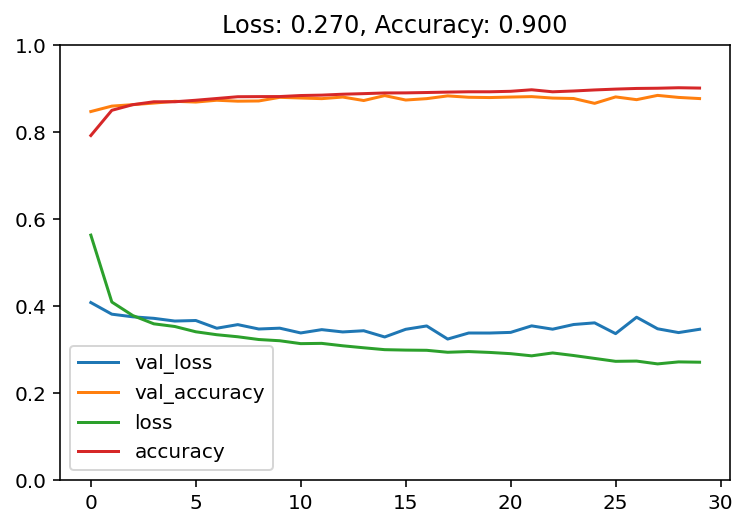

In [0]:
#TRIAL NO. 4
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 4')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 5
model = Sequential()
model.add(Dense(units=128, activation='sigmoid', input_shape=(image_vector_size,)))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 44us/step - loss: 0.5733 - accuracy: 0.7909 - val_loss: 0.4242 - val_accuracy: 0.8420
Epoch 2/50
54000/54000 [==============================] - 2s 42us/step - loss: 0.4277 - accuracy: 0.8454 - val_loss: 0.3932 - val_accuracy: 0.8570
Epoch 3/50
54000/54000 [==============================] - 2s 43us/step - loss: 0.3952 - accuracy: 0.8567 - val_loss: 0.3580 - val_accuracy: 0.8733
Epoch 4/50
54000/54000 [==============================] - 2s 41us/step - loss: 0.3745 - accuracy: 0.8634 - val_loss: 0.3820 - val_accuracy: 0.8603
Epoch 5/50
54000/54000 [==============================] - 2s 40us/step - loss: 0.3706 - accuracy: 0.8655 - val_loss: 0.3848 - val_accuracy: 0.8573
Epoch 6/50
54000/54000 [==============================] - 2s 41us/step - loss: 0.3582 - accuracy: 0.8699 - val_loss: 0.3659 - val_accuracy: 0.8677
Epoch 7/50
54000/54000 [==============================] - 2s 40us/ste

TRIAL NO. 5
Test loss: 0.374
Test accuracy: 0.869


<Figure size 576x432 with 0 Axes>

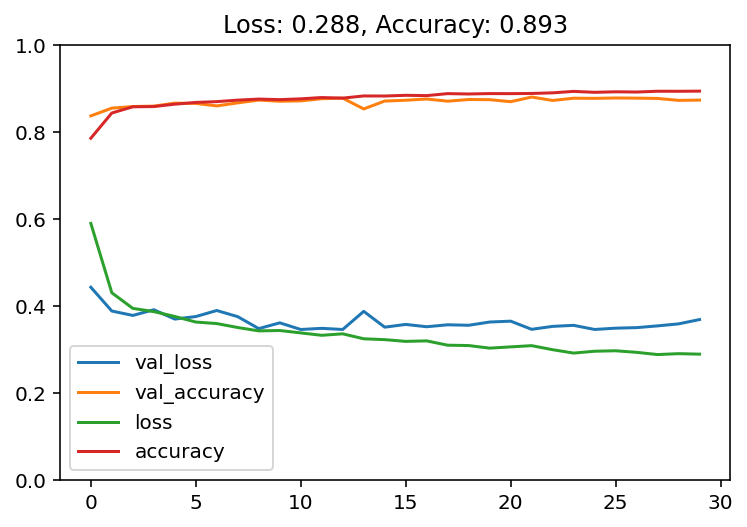

In [0]:
#TRIAL NO. 5
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 5')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 6
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =nadam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=512, epochs=20, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 22us/step - loss: 0.7682 - accuracy: 0.7259 - val_loss: 0.4754 - val_accuracy: 0.8215
Epoch 2/20
54000/54000 [==============================] - 1s 19us/step - loss: 0.4529 - accuracy: 0.8330 - val_loss: 0.4326 - val_accuracy: 0.8428
Epoch 3/20
54000/54000 [==============================] - 1s 20us/step - loss: 0.3956 - accuracy: 0.8527 - val_loss: 0.4313 - val_accuracy: 0.8435
Epoch 4/20
54000/54000 [==============================] - 1s 19us/step - loss: 0.3640 - accuracy: 0.8661 - val_loss: 0.3955 - val_accuracy: 0.8612
Epoch 5/20
54000/54000 [==============================] - 1s 20us/step - loss: 0.5594 - accuracy: 0.8146 - val_loss: 0.5825 - val_accuracy: 0.7748
Epoch 6/20
54000/54000 [==============================] - 1s 20us/step - loss: 0.4180 - accuracy: 0.8483 - val_loss: 0.3960 - val_accuracy: 0.8545
Epoch 7/20
54000/54000 [==============================] - 1s 20us/ste

TRIAL NO. 6
Test loss: 0.391
Test accuracy: 0.865


<Figure size 576x432 with 0 Axes>

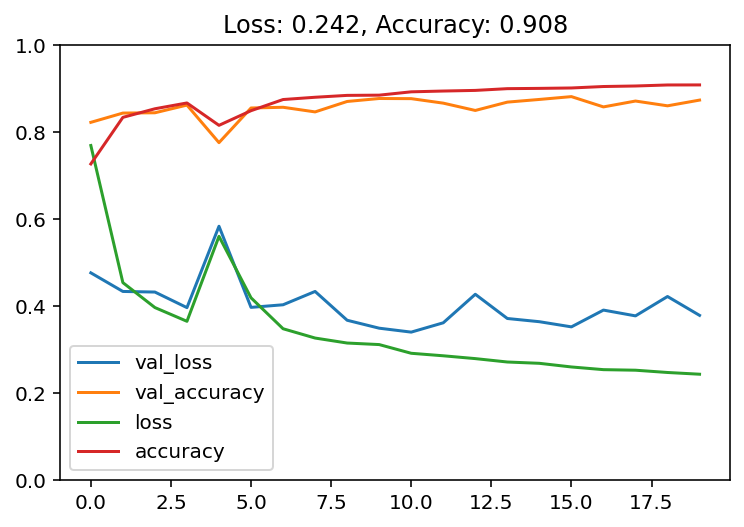

In [0]:
#TRIAL NO. 6
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 6')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 7
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =sgd(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=512, epochs=20, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 18us/step - loss: 1.7055 - accuracy: 0.5397 - val_loss: 1.2896 - val_accuracy: 0.6655
Epoch 2/20
54000/54000 [==============================] - 1s 17us/step - loss: 1.1103 - accuracy: 0.6786 - val_loss: 0.9592 - val_accuracy: 0.7012
Epoch 3/20
54000/54000 [==============================] - 1s 17us/step - loss: 0.8978 - accuracy: 0.7159 - val_loss: 0.8225 - val_accuracy: 0.7378
Epoch 4/20
54000/54000 [==============================] - 1s 17us/step - loss: 0.7975 - accuracy: 0.7427 - val_loss: 0.7493 - val_accuracy: 0.7498
Epoch 5/20
54000/54000 [==============================] - 1s 17us/step - loss: 0.7357 - accuracy: 0.7600 - val_loss: 0.7069 - val_accuracy: 0.7590
Epoch 6/20
54000/54000 [==============================] - 1s 17us/step - loss: 0.6918 - accuracy: 0.7734 - val_loss: 0.6615 - val_accuracy: 0.7757
Epoch 7/20
54000/54000 [==============================] - 1s 17us/ste

TRIAL NO. 7
Test loss: 0.52
Test accuracy: 0.819


<Figure size 576x432 with 0 Axes>

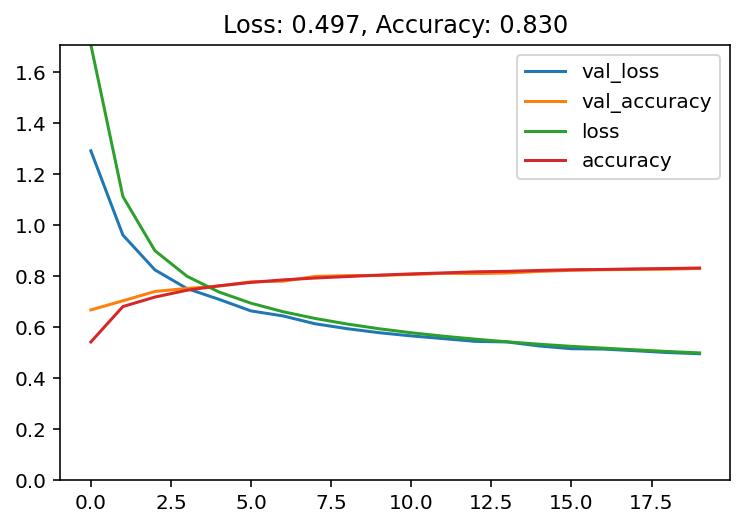

In [0]:
#TRIAL NO. 7
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 7')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 8
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =rmsprop(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=512, epochs=20, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 20us/step - loss: 1.3032 - accuracy: 0.6613 - val_loss: 0.6944 - val_accuracy: 0.7218
Epoch 2/20
54000/54000 [==============================] - 1s 18us/step - loss: 0.5635 - accuracy: 0.7892 - val_loss: 0.4929 - val_accuracy: 0.8182
Epoch 3/20
54000/54000 [==============================] - 1s 19us/step - loss: 0.4887 - accuracy: 0.8187 - val_loss: 0.5566 - val_accuracy: 0.8083
Epoch 4/20
54000/54000 [==============================] - 1s 18us/step - loss: 0.4439 - accuracy: 0.8352 - val_loss: 0.4227 - val_accuracy: 0.8495
Epoch 5/20
54000/54000 [==============================] - 1s 19us/step - loss: 0.4152 - accuracy: 0.8454 - val_loss: 0.4559 - val_accuracy: 0.8502
Epoch 6/20
54000/54000 [==============================] - 1s 18us/step - loss: 0.3945 - accuracy: 0.8536 - val_loss: 0.3948 - val_accuracy: 0.8578
Epoch 7/20
54000/54000 [==============================] - 1s 18us/ste

TRIAL NO. 8
Test loss: 0.483
Test accuracy: 0.852


<Figure size 576x432 with 0 Axes>

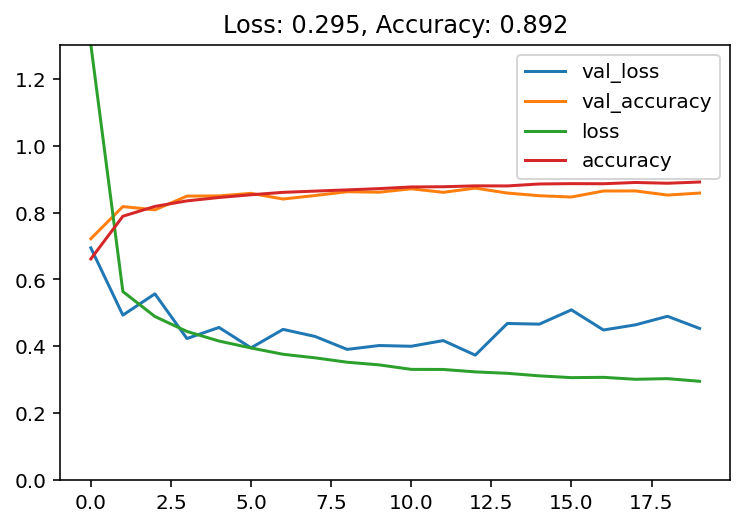

In [0]:
#TRIAL NO. 8
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 8')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 9
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adadelta(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=512, epochs=20, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 21us/step - loss: 2.2511 - accuracy: 0.1506 - val_loss: 2.0854 - val_accuracy: 0.2580
Epoch 2/20
54000/54000 [==============================] - 1s 20us/step - loss: 1.9683 - accuracy: 0.2989 - val_loss: 1.8323 - val_accuracy: 0.3728
Epoch 3/20
54000/54000 [==============================] - 1s 20us/step - loss: 1.7180 - accuracy: 0.4503 - val_loss: 1.5724 - val_accuracy: 0.5197
Epoch 4/20
54000/54000 [==============================] - 1s 20us/step - loss: 1.4553 - accuracy: 0.5770 - val_loss: 1.3212 - val_accuracy: 0.6183
Epoch 5/20
54000/54000 [==============================] - 1s 19us/step - loss: 1.2322 - accuracy: 0.6359 - val_loss: 1.1264 - val_accuracy: 0.6633
Epoch 6/20
54000/54000 [==============================] - 1s 19us/step - loss: 1.0759 - accuracy: 0.6691 - val_loss: 1.0031 - val_accuracy: 0.6887
Epoch 7/20
54000/54000 [==============================] - 1s 20us/ste

TRIAL NO. 9
Test loss: 0.657
Test accuracy: 0.78


<Figure size 576x432 with 0 Axes>

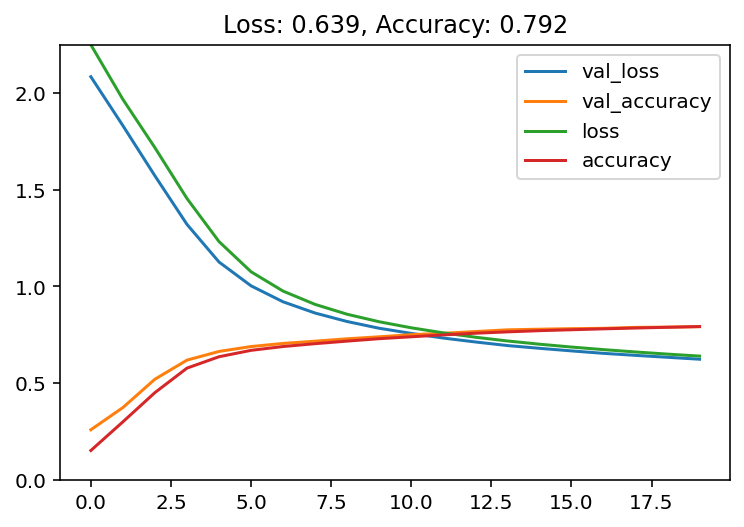

In [0]:
#TRIAL NO. 9
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 9')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 10
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adagrad(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=512, epochs=20, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 20us/step - loss: 0.8095 - accuracy: 0.7280 - val_loss: 0.5329 - val_accuracy: 0.8140
Epoch 2/20
54000/54000 [==============================] - 1s 18us/step - loss: 0.4860 - accuracy: 0.8308 - val_loss: 0.4539 - val_accuracy: 0.8382
Epoch 3/20
54000/54000 [==============================] - 1s 18us/step - loss: 0.4338 - accuracy: 0.8479 - val_loss: 0.4243 - val_accuracy: 0.8475
Epoch 4/20
54000/54000 [==============================] - 1s 18us/step - loss: 0.4031 - accuracy: 0.8577 - val_loss: 0.4042 - val_accuracy: 0.8575
Epoch 5/20
54000/54000 [==============================] - 1s 18us/step - loss: 0.3828 - accuracy: 0.8636 - val_loss: 0.3861 - val_accuracy: 0.8627
Epoch 6/20
54000/54000 [==============================] - 1s 18us/step - loss: 0.3682 - accuracy: 0.8681 - val_loss: 0.3810 - val_accuracy: 0.8637
Epoch 7/20
54000/54000 [==============================] - 1s 18us/ste

TRIAL NO. 10
Test loss: 0.349
Test accuracy: 0.874


<Figure size 576x432 with 0 Axes>

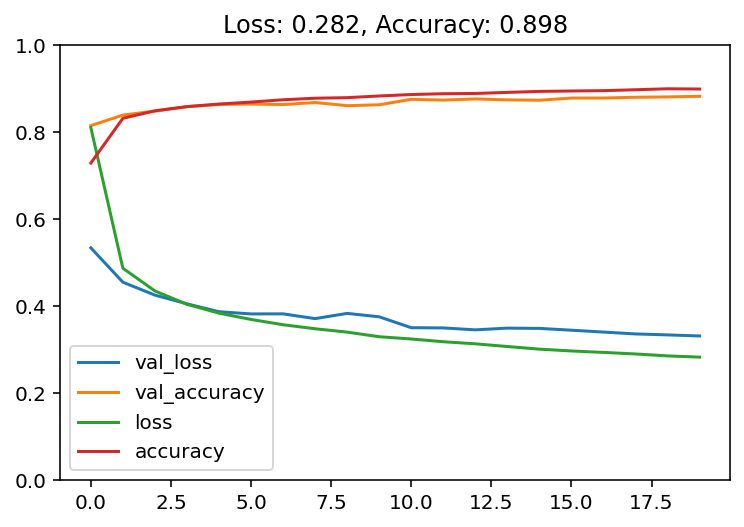

In [0]:
#TRIAL NO. 10
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 10')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 11
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 38us/step - loss: 0.5201 - accuracy: 0.8109 - val_loss: 0.4255 - val_accuracy: 0.8508
Epoch 2/50
54000/54000 [==============================] - 2s 37us/step - loss: 0.3959 - accuracy: 0.8569 - val_loss: 0.3974 - val_accuracy: 0.8633
Epoch 3/50
54000/54000 [==============================] - 2s 37us/step - loss: 0.3653 - accuracy: 0.8675 - val_loss: 0.3728 - val_accuracy: 0.8667
Epoch 4/50
54000/54000 [==============================] - 2s 38us/step - loss: 0.3553 - accuracy: 0.8695 - val_loss: 0.3863 - val_accuracy: 0.8683
Epoch 5/50
54000/54000 [==============================] - 2s 37us/step - loss: 0.3368 - accuracy: 0.8757 - val_loss: 0.4033 - val_accuracy: 0.8522
Epoch 6/50
54000/54000 [==============================] - 2s 37us/step - loss: 0.3310 - accuracy: 0.8773 - val_loss: 0.3577 - val_accuracy: 0.8722
Epoch 7/50
54000/54000 [==============================] - 2s 36us/ste

TRIAL NO. 11
Test loss: 0.484
Test accuracy: 0.875


<Figure size 576x432 with 0 Axes>

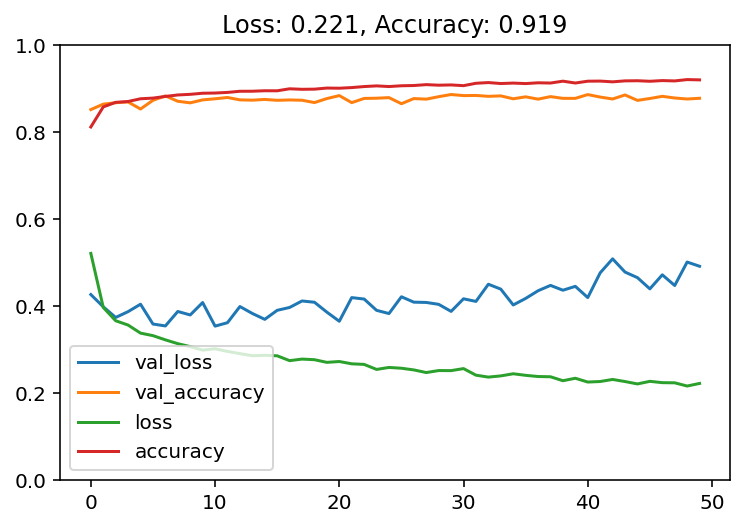

In [0]:
#TRIAL NO. 11
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 11')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 12
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adagrad(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 34us/step - loss: 0.5929 - accuracy: 0.7921 - val_loss: 0.4423 - val_accuracy: 0.8430
Epoch 2/50
54000/54000 [==============================] - 2s 33us/step - loss: 0.4191 - accuracy: 0.8521 - val_loss: 0.4118 - val_accuracy: 0.8522
Epoch 3/50
54000/54000 [==============================] - 2s 32us/step - loss: 0.3798 - accuracy: 0.8661 - val_loss: 0.3775 - val_accuracy: 0.8615
Epoch 4/50
54000/54000 [==============================] - 2s 32us/step - loss: 0.3565 - accuracy: 0.8738 - val_loss: 0.3687 - val_accuracy: 0.8718
Epoch 5/50
54000/54000 [==============================] - 2s 32us/step - loss: 0.3392 - accuracy: 0.8797 - val_loss: 0.3585 - val_accuracy: 0.8728
Epoch 6/50
54000/54000 [==============================] - 2s 33us/step - loss: 0.3258 - accuracy: 0.8840 - val_loss: 0.3452 - val_accuracy: 0.8728
Epoch 7/50
54000/54000 [==============================] - 2s 32us/ste

TRIAL NO. 12
Test loss: 0.325
Test accuracy: 0.886


<Figure size 576x432 with 0 Axes>

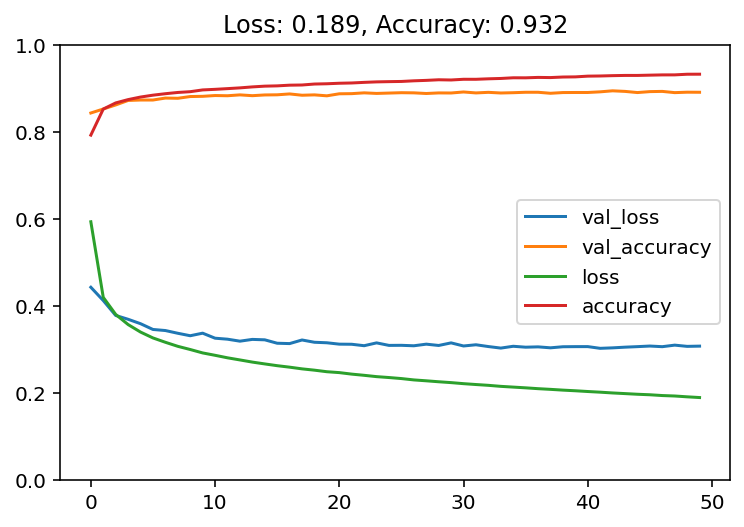

In [0]:
#TRIAL NO. 12
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 12')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 13
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adagrad(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 40us/step - loss: 0.6107 - accuracy: 0.7848 - val_loss: 0.4450 - val_accuracy: 0.8353
Epoch 2/50
54000/54000 [==============================] - 2s 38us/step - loss: 0.4464 - accuracy: 0.8437 - val_loss: 0.4010 - val_accuracy: 0.8582
Epoch 3/50
54000/54000 [==============================] - 2s 37us/step - loss: 0.4098 - accuracy: 0.8548 - val_loss: 0.3769 - val_accuracy: 0.8632
Epoch 4/50
54000/54000 [==============================] - 2s 37us/step - loss: 0.3872 - accuracy: 0.8623 - val_loss: 0.3665 - val_accuracy: 0.8683
Epoch 5/50
54000/54000 [==============================] - 2s 37us/step - loss: 0.3726 - accuracy: 0.8654 - val_loss: 0.3607 - val_accuracy: 0.8695
Epoch 6/50
54000/54000 [==============================] - 2s 37us/step - loss: 0.3603 - accuracy: 0.8709 - val_loss: 0.3523 - val_accuracy: 0.8725
Epoch 7/50
54000/54000 [==============================] - 2s 38us/ste

TRIAL NO. 13
Test loss: 0.315
Test accuracy: 0.892


<Figure size 576x432 with 0 Axes>

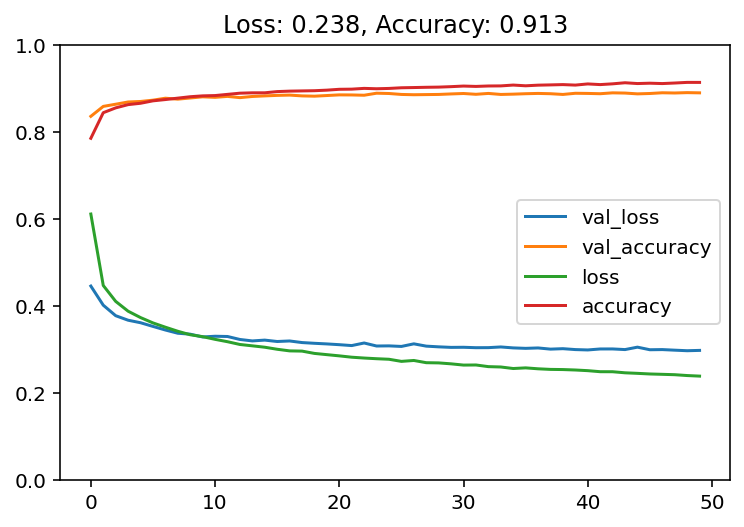

In [0]:
#TRIAL NO. 13
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 13')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 14
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adagrad(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 42us/step - loss: 0.6742 - accuracy: 0.7522 - val_loss: 0.4579 - val_accuracy: 0.8310
Epoch 2/50
54000/54000 [==============================] - 2s 40us/step - loss: 0.4769 - accuracy: 0.8282 - val_loss: 0.4114 - val_accuracy: 0.8505
Epoch 3/50
54000/54000 [==============================] - 2s 39us/step - loss: 0.4349 - accuracy: 0.8429 - val_loss: 0.3827 - val_accuracy: 0.8578
Epoch 4/50
54000/54000 [==============================] - 2s 39us/step - loss: 0.4099 - accuracy: 0.8523 - val_loss: 0.3689 - val_accuracy: 0.8613
Epoch 5/50
54000/54000 [==============================] - 2s 39us/step - loss: 0.3946 - accuracy: 0.8580 - val_loss: 0.3632 - val_accuracy: 0.8645
Epoch 6/50
54000/54000 [==============================] - 2s 39us/step - loss: 0.3802 - accuracy: 0.8626 - val_loss: 0.3504 - val_accuracy: 0.8688
Epoch 7/50
54000/54000 [==============================] - 2s 40us/ste

TRIAL NO. 14
Test loss: 0.325
Test accuracy: 0.887


<Figure size 576x432 with 0 Axes>

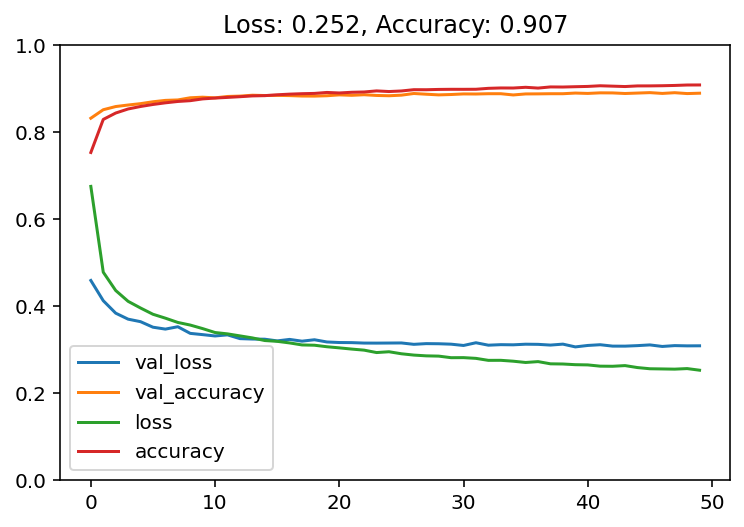

In [0]:
#TRIAL NO. 14
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 14')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 15
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =sgd(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 4s 81us/step - loss: 0.9495 - accuracy: 0.6629 - val_loss: 0.5695 - val_accuracy: 0.7988
Epoch 2/10
54000/54000 [==============================] - 4s 79us/step - loss: 0.6024 - accuracy: 0.7870 - val_loss: 0.4809 - val_accuracy: 0.8315
Epoch 3/10
54000/54000 [==============================] - 4s 79us/step - loss: 0.5254 - accuracy: 0.8146 - val_loss: 0.4370 - val_accuracy: 0.8398
Epoch 4/10
54000/54000 [==============================] - 4s 79us/step - loss: 0.4851 - accuracy: 0.8280 - val_loss: 0.4157 - val_accuracy: 0.8473
Epoch 5/10
54000/54000 [==============================] - 4s 78us/step - loss: 0.4562 - accuracy: 0.8372 - val_loss: 0.4052 - val_accuracy: 0.8525
Epoch 6/10
54000/54000 [==============================] - 4s 79us/step - loss: 0.4368 - accuracy: 0.8447 - val_loss: 0.3807 - val_accuracy: 0.8607
Epoch 7/10
54000/54000 [==============================] - 4s 78us/ste

TRIAL NO. 15
Test loss: 0.38
Test accuracy: 0.866


<Figure size 576x432 with 0 Axes>

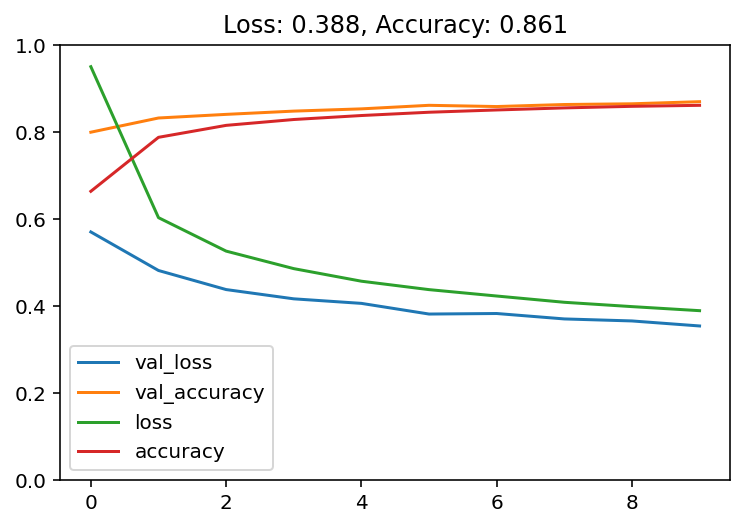

In [0]:
#TRIAL NO. 15
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 15')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 16
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adagrad(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 5s 96us/step - loss: 0.6173 - accuracy: 0.7773 - val_loss: 0.4361 - val_accuracy: 0.8427
Epoch 2/10
54000/54000 [==============================] - 5s 93us/step - loss: 0.4551 - accuracy: 0.8378 - val_loss: 0.3912 - val_accuracy: 0.8577
Epoch 3/10
54000/54000 [==============================] - 5s 93us/step - loss: 0.4147 - accuracy: 0.8516 - val_loss: 0.3771 - val_accuracy: 0.8623
Epoch 4/10
54000/54000 [==============================] - 5s 92us/step - loss: 0.3932 - accuracy: 0.8598 - val_loss: 0.3617 - val_accuracy: 0.8680
Epoch 5/10
54000/54000 [==============================] - 5s 93us/step - loss: 0.3805 - accuracy: 0.8643 - val_loss: 0.3544 - val_accuracy: 0.8712
Epoch 6/10
54000/54000 [==============================] - 5s 92us/step - loss: 0.3678 - accuracy: 0.8672 - val_loss: 0.3551 - val_accuracy: 0.8722
Epoch 7/10
54000/54000 [==============================] - 5s 92us/ste

TRIAL NO. 16
Test loss: 0.359
Test accuracy: 0.873


<Figure size 576x432 with 0 Axes>

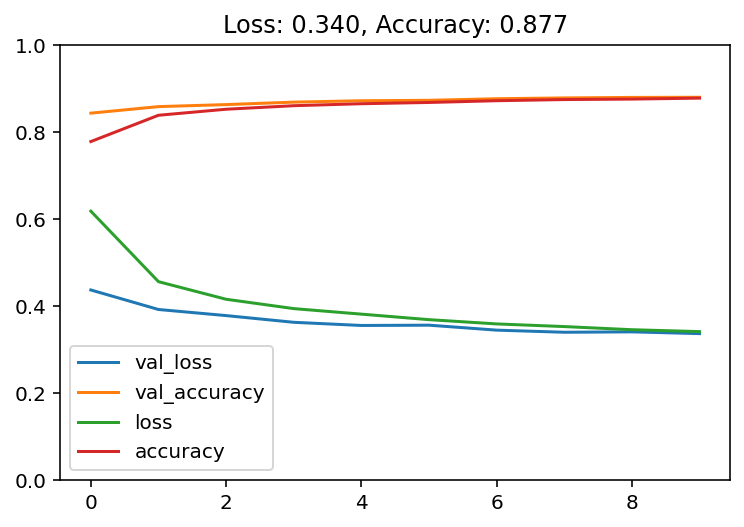

In [0]:
#TRIAL NO. 16
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 16')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 17
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adagrad(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 5s 96us/step - loss: 0.6209 - accuracy: 0.7752 - val_loss: 0.4393 - val_accuracy: 0.8402
Epoch 2/50
54000/54000 [==============================] - 5s 92us/step - loss: 0.4595 - accuracy: 0.8337 - val_loss: 0.3879 - val_accuracy: 0.8545
Epoch 3/50
54000/54000 [==============================] - 5s 91us/step - loss: 0.4189 - accuracy: 0.8510 - val_loss: 0.3708 - val_accuracy: 0.8650
Epoch 4/50
54000/54000 [==============================] - 5s 92us/step - loss: 0.3970 - accuracy: 0.8553 - val_loss: 0.3586 - val_accuracy: 0.8637
Epoch 5/50
54000/54000 [==============================] - 5s 94us/step - loss: 0.3839 - accuracy: 0.8627 - val_loss: 0.3514 - val_accuracy: 0.8705
Epoch 6/50
54000/54000 [==============================] - 5s 92us/step - loss: 0.3699 - accuracy: 0.8649 - val_loss: 0.3464 - val_accuracy: 0.8720
Epoch 7/50
54000/54000 [==============================] - 5s 92us/ste

TRIAL NO. 17
Test loss: 0.33
Test accuracy: 0.887


<Figure size 576x432 with 0 Axes>

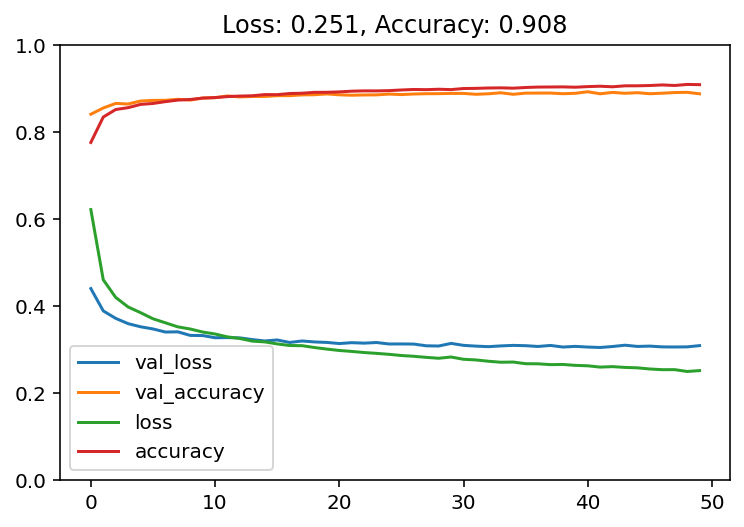

In [0]:
#TRIAL NO. 17
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 17')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
#TRIAL NO. 18
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(image_vector_size,)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer =adagrad(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 5s 94us/step - loss: 0.5679 - accuracy: 0.7980 - val_loss: 0.4218 - val_accuracy: 0.8480
Epoch 2/50
54000/54000 [==============================] - 5s 93us/step - loss: 0.4319 - accuracy: 0.8460 - val_loss: 0.3854 - val_accuracy: 0.8583
Epoch 3/50
54000/54000 [==============================] - 5s 90us/step - loss: 0.3966 - accuracy: 0.8583 - val_loss: 0.3761 - val_accuracy: 0.8598
Epoch 4/50
54000/54000 [==============================] - 5s 88us/step - loss: 0.3763 - accuracy: 0.8659 - val_loss: 0.3599 - val_accuracy: 0.8697
Epoch 5/50
54000/54000 [==============================] - 5s 88us/step - loss: 0.3612 - accuracy: 0.8698 - val_loss: 0.3516 - val_accuracy: 0.8722
Epoch 6/50
54000/54000 [==============================] - 5s 87us/step - loss: 0.3515 - accuracy: 0.8730 - val_loss: 0.3441 - val_accuracy: 0.8702
Epoch 7/50
54000/54000 [==============================] - 5s 88us/ste

TRIAL NO. 17
Test loss: 0.319
Test accuracy: 0.889


<Figure size 576x432 with 0 Axes>

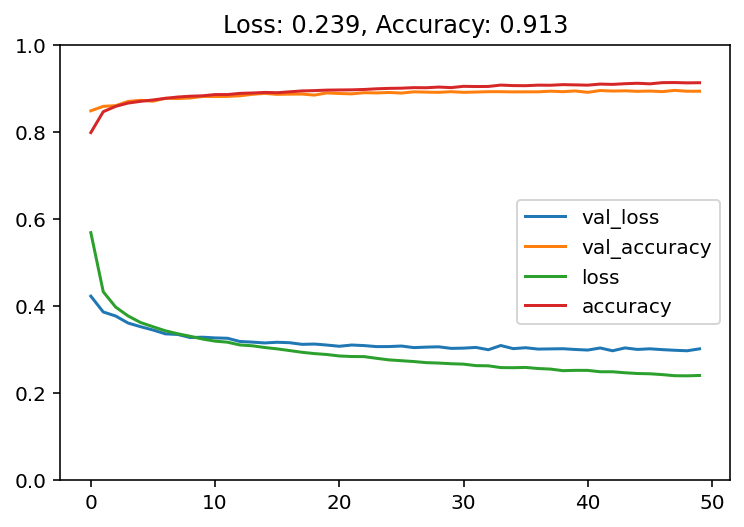

In [0]:
#TRIAL NO. 18
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print('TRIAL NO. 18')
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')